In [1]:
%pylab inline

import pyart
import pandas as pd
import os
import datetime as dt
import seaborn as sns
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

import pint
import metpy.calc as mpcalc

Populating the interactive namespace from numpy and matplotlib

## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/wradlib/io/radolan.py:835: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'RR': {'add_offset': np.float(0),
/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/wradlib/io/radolan.py:842: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'RA': {'add_offset': np.float(0),


### Read data

In [2]:
path_file = '/home/icrisologo/Data/'
fname = 'ERA5_1996_2019_600hPa_1000hPa.nc'

In [3]:
ds = xr.open_dataset(os.path.join(path_file,fname))

### Read variables

In [4]:
lat = ds['latitude'] # shape: (19,)
lon = ds['longitude'] # shape: (27,)
level = ds['level'] # shape: (12,)
time = ds['time'] # shape: (6912,)
temp = ds['t'] # shape: (6912, 12, 19, 27)

In [5]:
level

<xarray.DataArray 'level' (level: 14)>
array([ 600,  650,  700,  750,  775,  800,  825,  850,  875,  900,  925,  950,
        975, 1000], dtype=int32)
Coordinates:
  * level    (level) int32 600 650 700 750 775 800 ... 875 900 925 950 975 1000
Attributes:
    units:      millibars
    long_name:  pressure_level

### Explore data

##### Plot one slice

In [6]:
temp_slice = temp[1000,7,:,:] - 273.15

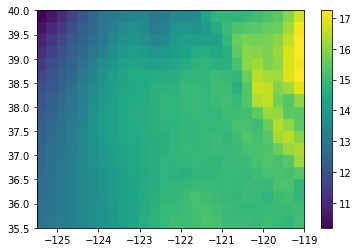

In [7]:
qmesh = plt.pcolormesh(lon.values,lat.values,temp_slice.data)
ax1 = plt.gca()
cb = plt.colorbar(qmesh,ax=ax1)

##### Plot one column

In [8]:
temp_col = temp[500,:,10,15] - 273.15

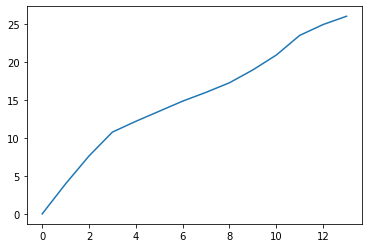

In [9]:
plt.plot(temp_col)

### Extract time-series of temperature column in a single location 

In [10]:
%%time

# testing for location [10,15] (in array indices)

temp_col_tseries = []
level_at_zero = []
for i in range(len(time)):
    temp_col = temp[i,:,10,15] - 273.15
    #level_ = level.data[np.where(temp_col.data==np.min(abs(temp_col.data)))]
    level_ = level.data[np.where((temp_col.data<=3.0)&(temp_col.data>=1.0))]
    if len(level_)==0:
        level_at_zero.append(np.nan)
    else:
        #level_at_zero.append(level_[0])
        level_at_zero.append(np.nanmean(level_))
    temp_col_tseries.append(temp_col.data)

CPU times: user 6.38 s, sys: 111 ms, total: 6.49 s
Wall time: 6.49 s


In [11]:
# convert list to array
temp_col_tseries = np.array(temp_col_tseries)

##### Plot time series

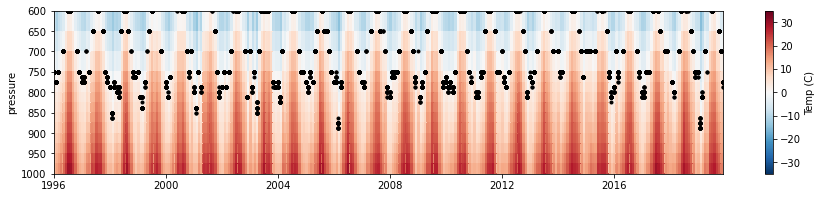

In [12]:
fig = plt.figure(figsize=(15,3))

ax1 = fig.add_subplot(111)
qmesh = plt.pcolormesh(time.data, level.data, temp_col_tseries.T, 
                       cmap='RdBu_r', vmin=-35, vmax=35)
ax1 = plt.gca()
cb = fig.colorbar(qmesh,ax=ax1)
cb.set_label('Temp (C)')
ax1.plot(time.data,level_at_zero,'ko',ms=3)
ax1.axis('tight')
ax1.set_ylabel('pressure')
# Set up as dates
ax1.xaxis_date()
plt.gca().invert_yaxis()

The time series plot above shows the temperature of a column of atmosphere over the location with [10,15] index coordinates over the entire time period. The red vertical bands correspond to summer months, and blue vertical bands correspond to winter months.

The **black dots** correspond to the pressure level where the temperature is closest to 0 deg C. 

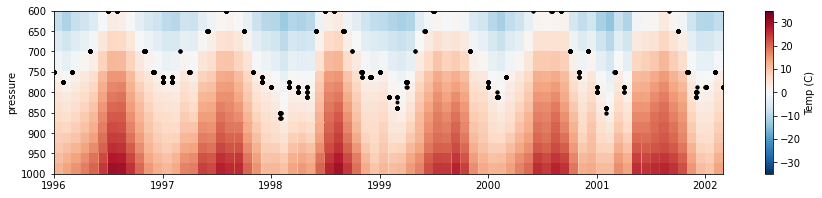

In [13]:
fig = plt.figure(figsize=(15,3))

ax1 = fig.add_subplot(111)
qmesh = plt.pcolormesh(time.data[:1800], level.data[:1800], temp_col_tseries[:1800].T, 
                       cmap='RdBu_r', vmin=-35, vmax=35)
ax1 = plt.gca()
cb = fig.colorbar(qmesh,ax=ax1)
cb.set_label('Temp (C)')
ax1.plot(time.data[:1800],level_at_zero[:1800],'ko',ms=3)
ax1.axis('tight')
ax1.set_ylabel('pressure')
# Set up as dates
ax1.xaxis_date()
plt.gca().invert_yaxis()

In [14]:
height_std = mpcalc.pressure_to_height_std(level)

In [15]:
height_std

Magnitude,[4.204157802769398 3.588751462706507 3.010558025783667 2.464895554945448 2.2030401123457213 1.947937573358983 1.6992107001633152 1.4565139962849931 1.2195301902939262 0.9879671974242984 0.7615554828072778 0.5400457639046174 0.3232070008045167 0.11082463191827029]
Units,kilometer


In [17]:
# lat = ds['latitude'] # shape: (19,)
# lon = ds['longitude'] # shape: (27,)
# level = ds['level'] # shape: (12,)
# time = ds['time'] # shape: (6912,)
# temp = ds['t'] # shape: (6912, 12, 19, 27)



# testing for location [10,15] (in array indices)
ureg = pint.UnitRegistry()

temp_col_tseries = []
level_at_zero = []
height_hydrostatic = []
for i in range(len(time)):
    temp_col = temp[i,:,10,15]
    
    level_ = level.data[np.where((temp_col.data<=(3.0+273.15))&(temp_col.data>=(1.0+273.15)))]
    temp_ = temp_col.data[np.where((temp_col.data<=(3.0+273.15))&(temp_col.data>=(1.0+273.15)))]
    
    if len(level_)==0:
        level_at_zero.append(np.nan)
        height_hydrostatic.append(np.nan)
    else:
        level_at_zero.append(np.nanmean(level_))
        height_hydro_ = mpcalc.thickness_hydrostatic(pressure=level_*ureg.millibars,temperature=temp_*ureg.kelvin)
        height_hydrostatic.append(height_hydro_)
        print(height_hydro_)
    temp_col_tseries.append(temp_col.data)
    

-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter

-240.73036278177332 meter
-488.201047498472 meter
-247.50809588087265 meter
-247.5884691103912 meter
-247.63228406519718 meter
-247.64795189721684 meter
-247.62423024979054 meter
-247.54707304894973 meter
-247.45466032745816 meter
-240.7202294051061 meter
-240.57169543658884 meter
-240.42742815298405 meter
-240.28321420294074 meter
-240.27580083790517 meter
-240.21729392104223 meter
-240.18689379104046 meter
-240.23526733123623 meter
-240.2523874044477 meter
-240.24342736613144 meter
-240.25590741950055 meter
-240.2294006394815 meter
-240.2407073544997 meter
-240.43172150467728 meter
-240.42550814477343 meter
-255.86267336432627 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-255.9074540973852 meter
-255.87801622473464 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 mete

-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-247.6672205818586 meter
-247.7082043319312 meter
-247.7829701268322 meter
-247.78657097945424 meter
-247.86455280303295 meter
-247.92480523774725 meter
-247.9665861231331 meter
-248.0096039426258 meter
-247.9794777252686 meter
-247.95897210652004 meter
-247.9119411230364 meter
-247.88423379904364 meter
-247.7488032580594 meter
-247.79660

-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter

-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter

-248.03491986067863 meter
-247.94731743849135 meter
-247.9260146844295 meter
-248.07953195079787 meter
-248.18882195099138 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-264.34386325006056 meter
-264.18030681941076 meter
-264.0826533201653 meter
-264.0976498983338 meter
-264.0861095627901 meter
-264.05482763801683 meter
-264.0192693452502 meter
-263.9593416129599 meter
-263.88441730250105 meter
-263.87756339763496 meter
-263.91224298464954 meter
-264.00731894702227 meter
-264.071523047306 meter
-263.95676407608715 meter
-264.11135770806595 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0

-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter

-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-264.4423368746745 meter
-264.40209215123025 meter
-0.0 meter
-0.0 meter
-264.3399969447515 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-264.36829126996776 meter
-264.4157999609623 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-0.0 meter
-233.17968698794533 meter
-233.22624389770743 meter
-233.18952660179937 meter
-233.1066149082186 meter
-233.14069104461845 meter
-0.0 meter
-0.0 meter
-227.18979506869925 meter
-227.1419578822803 meter
-227.06875515987488 meter
-227.04336445966618 meter
-226.97529523859137 meter
-226.9223245508418 meter
-226.88442723219535 meter
-226.90211768040814 meter
-226.92048756262056 meter
-227.04776819855272 meter
-0.0 meter
-0.0 meter
-0.0 meter
-247.94652030317806 meter
-248.09440264750427 

In [17]:
height_hydro_

0.0 <Unit('meter')>

In [18]:
temp_col_tseries = np.array(temp_col_tseries)

In [19]:
height_hydros = []
for he in height_hydrostatic:
    if not isnan(he):
        height_hydros.append(he.magnitude)
    else:
        height_hydros.append(np.nan)

#x = np.array([measure.to_base_units().magnitude for measure in measures])

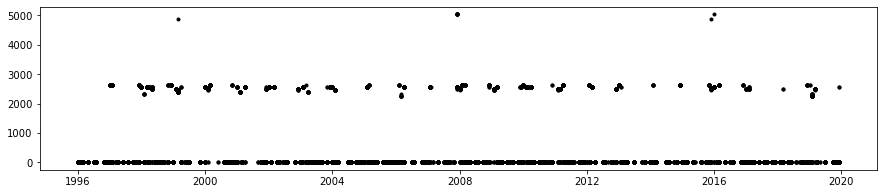

In [20]:
fig = plt.figure(figsize=(15,3))

ax1 = fig.add_subplot(111)
#qmesh = plt.pcolormesh(time.data, level.data, temp_col_tseries.T, 
#                       cmap='RdBu_r', vmin=-35, vmax=35)
#ax1 = plt.gca()
#cb = fig.colorbar(qmesh,ax=ax1)
#cb.set_label('Temp (C)')
ax1.plot(time.data,height_hydros,'ko',ms=3)
ax1.axis('tight')
#ax1.set_ylabel('pressure')
# Set up as dates
ax1.xaxis_date()
#plt.gca().invert_yaxis()

(0.0, 5000.0)

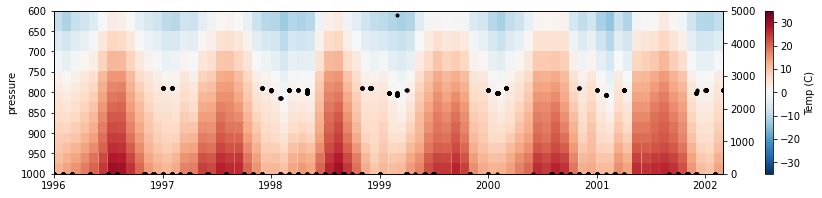

In [22]:
fig = plt.figure(figsize=(15,3))

ax1 = fig.add_subplot(111)
qmesh = plt.pcolormesh(time.data[:1800], level.data[:1800], temp_col_tseries[:1800].T-273.15, 
                       cmap='RdBu_r', vmin=-35, vmax=35)
ax1 = plt.gca()
cb = fig.colorbar(qmesh,ax=ax1)
cb.set_label('Temp (C)')
#ax1.plot(time.data[:1800],height_hydros[:1800],'ko',ms=3)
ax1.axis('tight')
ax1.set_ylabel('pressure')
# Set up as dates
ax1.xaxis_date()
plt.gca().invert_yaxis()

ax2=ax1.twinx()
ax2.plot(time.data[:1800],height_hydros[:1800],'ko',ms=3)
ax2.set_ylim([0,5000])